# Updates from my work!


### Change of data

I changed the data from `MOD09GA` to `MOD09A1`. The later contains a cloud QA layer that's the same resolution as the regular MODIS, aka 500m. The former has a cloud layer that's 1km resolution.  This makes it so that it has a different extent than the regular layers, as well as a different shape. Even if we resampled the array to have the same resolution as the regular layers, the array would still not be able to be multiplied, due to the differing extent. The layer is not named QC, that is a different layer that stores data quality values. The layer is called `sur_refl_state_500m` in the `MOD09A1` data. We decided it was easier to change the dataset, as the data is virtually identical.

### Masking Values

I was unable to decipher the NASA documentation for what the values in the `sur_refl_state_500m` layer mean. They say it is bit data with different information stored in different bits. This was a bit beyond me, so check out this documentation and see if it makes any more sense to you! The document is [here](https://modis-land.gsfc.nasa.gov/pdf/MOD09_UserGuide_v1.4.pdf). If you go to table 13 in that document it has the breakdown of all of the bits and what they represent. For reference, the values found in the layers we collected are `72, 80, 136`. However, once we decipher which of those values are clouds, it's fairly easy to mask all of the values! It works just like landsat values, where you pass it the masking layer and the values to be masked. 

### Things left to do

With the change of data source, I think everything that we originally intended to do with this notebook is possible, and I outlined code examples of how to do everything originally intended in the cells below. If we were to incorporate GDAL into this, that still has to be done. Once the cloud values are figured out, masking should be added to the helper function in the place I marked with a comment. Besides that, I think this has everything (or at least the start of everything) that the asana task called for!

In [1]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em

# Stops notebook from throwing NotGeoreferencedWarning everytime it opens up a file from the Modis data
import warnings
import rasterio
warnings.filterwarnings(
    "ignore", category=rasterio.errors.NotGeoreferencedWarning)

os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))
os.getcwd()

'/home/nathan/earth-analytics/data'

In [2]:
et.data.get_data("cold-springs-fire")
et.data.get_data("cold-springs-modis-h5")

'/home/nathan/earth-analytics/data/cold-springs-modis-h5/.'

In [3]:
# Open fire boundary
fire_boundary_path = os.path.join("cold-springs-fire", "vector_layers",
                                  "fire-boundary-geomac", "co_cold_springs_20160711_2200_dd83.shp")
fire_boundary = gpd.read_file(fire_boundary_path)

In [4]:
# PRE DATA: .2016191073856_sur_refl_b02_1 the data that i'm looking for
# POST DATA: 006.2016201065406_sur_refl_b04_1

pre_fire_path = os.path.join(
    "cold-springs-modis-h5", "03_july_2016", "MOD09A1.A2016193.h09v05.006.2016202084416.hdf")
post_fire_path = os.path.join(
    "cold-springs-modis-h5", "11_july_2016", "MOD09A1.A2016185.h09v05.006.2016194193322.hdf")

Note that rasterio does handle sub datasets.
It is import to read each array as a 2 dim arr to make for easier plotting after the data are stacked. 

In [5]:
# Added this helper function to make the flow of the program easier. It's sloppy right now, but could be cleaned up


def open_h4_bands_crop(modis_path, re_search, bound):
    """Helper Function"""
    bands = []
    bands_meta = []
    with rio.open(modis_path) as dataset:
        for name in dataset.subdatasets:
            # Build out content on regex
            if re.search(re_search, name):
                with rio.open(name) as subdataset:
                    # This is not ideal because it's reprojecting each time...
                    # I was unable to find a way around this
                    boundary_project = bound.to_crs(subdataset.crs)
                    crop_band, crop_meta = es.crop_image(
                        subdataset, boundary_project)
                    # subdataset.meta I didn't keep this object bc I wasn't really sure what use it
                    # was compared to the metadata we are already getting from crop_image

                    # If we were going to mask the data, it would be around here in the function

                    # read in the data as a 2 dim vs 3 dim arr
                    # all_bands.append(subdataset.read(1))
                    bands.append(np.squeeze(crop_band))
                    bands_meta.append(crop_meta)

    extent = plotting_extent(bands[0], crop_meta["transform"])
    # Using np.stack here since this is a list of numpy arrays, not a list of file paths that lead to
    # files for individual bands.
    return np.stack(bands), bands_meta, extent, boundary_project

In [6]:
# Importing the cloud mask data

pre_fire_modis_cloud, pre_fire_modis_crop_meta_cloud, extent_modis_pre_cloud, _ = open_h4_bands_crop(
    pre_fire_path, "state_500m", fire_boundary)

In [7]:
# Importing the cloud mask data

post_fire_modis_cloud, post_fire_modis_crop_meta_cloud, extent_modis_post_cloud, _ = open_h4_bands_crop(
    post_fire_path, "state_500m", fire_boundary)

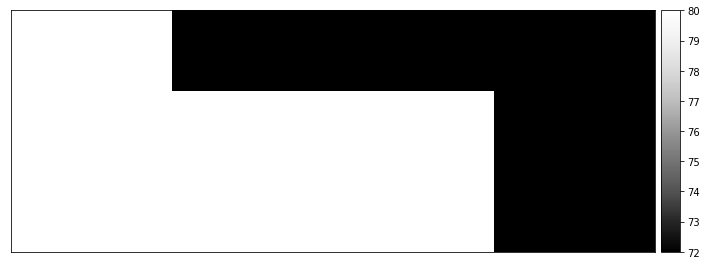

In [8]:
# Plotting the cloud data

ep.plot_bands(pre_fire_modis_cloud, scale=False, extent=extent_modis_pre_cloud)

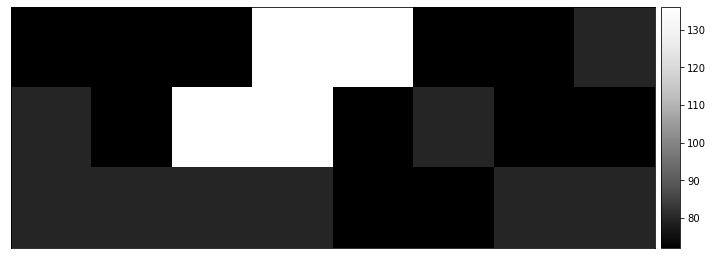

In [9]:
# Plotting the cloud data

ep.plot_bands(post_fire_modis_cloud, scale=False,
              extent=extent_modis_pre_cloud)

In [10]:
# Import the data using rasterio
# this could easily become a helper function -- assuming the students needed to import multiple datasets

pre_fire_modis, pre_fire_modis_crop_meta, extent_modis_pre, fire_bound_sin = open_h4_bands_crop(
    pre_fire_path, "refl_b", fire_boundary)

In [11]:
post_fire_modis, post_fire_modis_crop_meta, extent_modis_post, _ = open_h4_bands_crop(
    post_fire_path, "refl_b", fire_boundary)

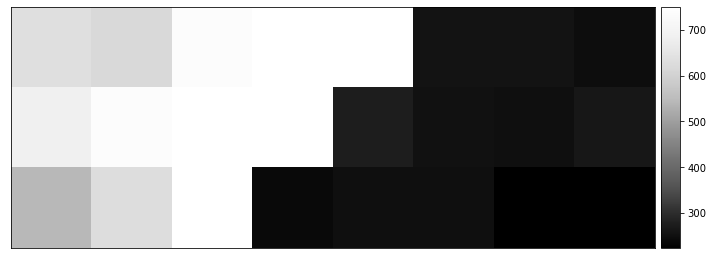

In [12]:
# Example of masking the data if 136 was the cloud value

mask = em.mask_pixels(post_fire_modis[0], post_fire_modis_cloud[0], [136])
ep.plot_bands(mask, scale=False)

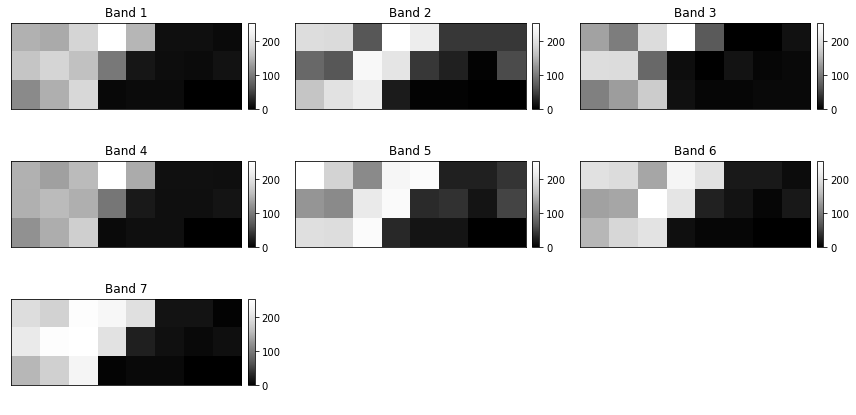

In [13]:
# Plot the data
ep.plot_bands(post_fire_modis, figsize=(12, 6))
plt.show()

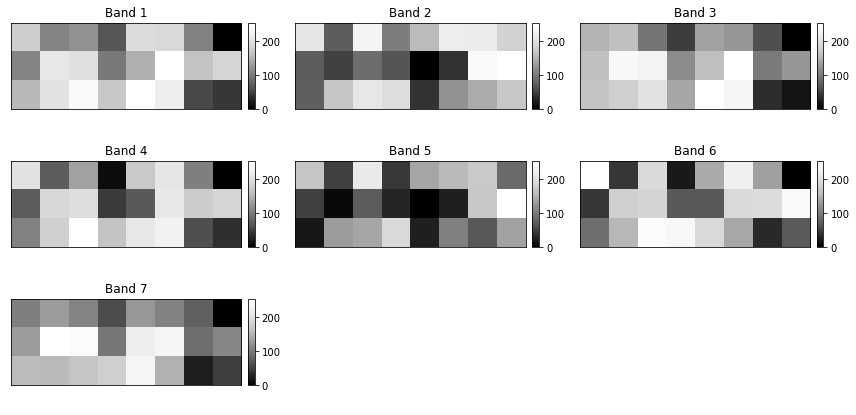

In [14]:
# Plot the data
ep.plot_bands(pre_fire_modis, figsize=(12, 6))
plt.show()

This is the same answer that we have on the homeworks i believe!

It was the same answer, but it's changed with the new data

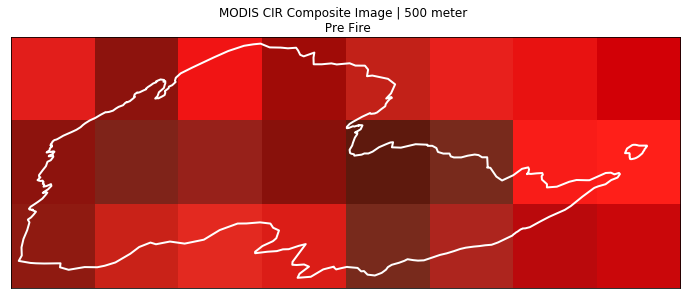

In [15]:
# Plotting the CIR of the pre fire data

fig, ax = plt.subplots(figsize=(12, 12))
ep.plot_rgb(pre_fire_modis, ax=ax,
            rgb=[1, 0, 3],
            extent=extent_modis_post,
            title="MODIS CIR Composite Image | 500 meter \n Pre Fire")
fire_bound_sin.plot(ax=ax, color='None',
                    edgecolor='white', linewidth=2)
plt.show()

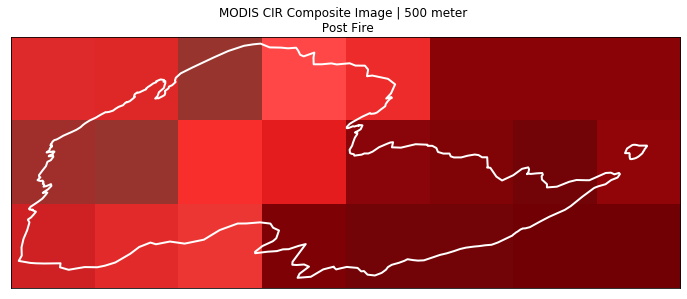

In [16]:
# Plotting the CIR of the post fire data

fig, ax = plt.subplots(figsize=(12, 12))
ep.plot_rgb(post_fire_modis, ax=ax,
            rgb=[1, 0, 3],
            extent=extent_modis_post,
            title="MODIS CIR Composite Image | 500 meter \n Post Fire")
fire_bound_sin.plot(ax=ax, color='None',
                    edgecolor='white', linewidth=2)
plt.show()

In [17]:
# Making the dnbr class

pre_ndb = es.normalized_diff(pre_fire_modis[1], pre_fire_modis[6])
post_ndb = es.normalized_diff(post_fire_modis[1], post_fire_modis[6])
dnbr = pre_ndb - post_ndb

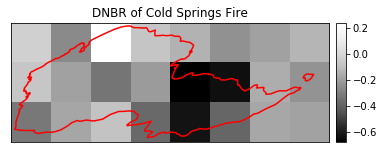

In [18]:
fig, ax = plt.subplots()
ep.plot_bands(dnbr, extent=extent_modis_post, ax=ax,
              title="DNBR of Cold Springs Fire", scale=False)
fire_bound_sin.boundary.plot(ax=ax, color='red')
plt.show()

(<Figure size 864x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5885d10290>)

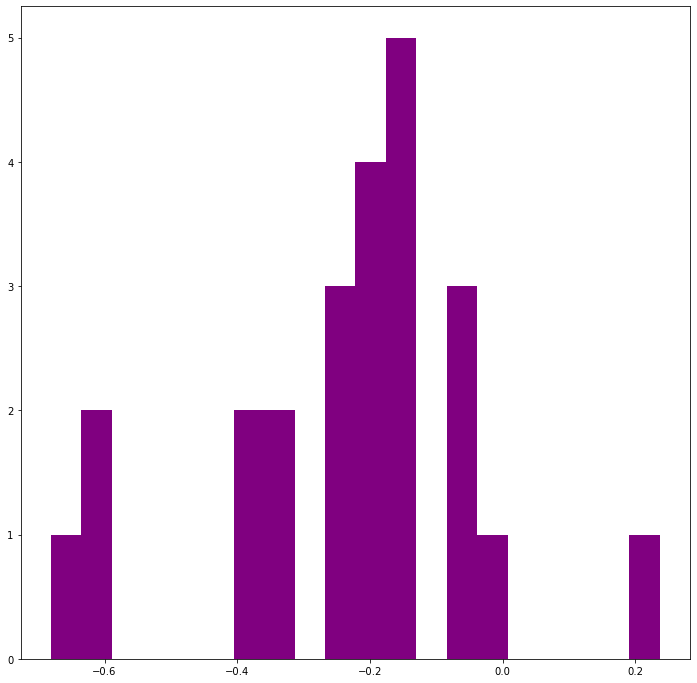

In [19]:
# Histogram of the data to show splits for classification if desired?

ep.hist(dnbr)

In [20]:
# Exporting the data to a GeoTiff

meta = post_fire_modis_crop_meta[0]
# The datatype changes when the raster math is done on it, so we have to change the data from an
# int to a float to preserve the newly calculated values

meta['dtype'] = 'float64'

# If we are masking the nodata values out for clouds, we need to update the nodata value in this metadata object

out_path = os.path.join("outputs", "dnbr.tif")

with rio.open(out_path, 'w', **meta) as outf:
    outf.write(dnbr, 1)

In [21]:
# Open the data using GDAL
# pre_fire_modis = gdal.Open(pre_fire_path)
# modis_data = gdal.Open("modis-06-july-2016/MOD09GA.A2016188.h09v05.006.2016190063623.hdf")
#  for path, desc in modis_data.GetSubDatasets():
#       print(path, "then", desc)

In [22]:
# Get reflectance data and stack
# path = ''
# all_data = []
# for data, desc in pre_fire_modis.GetSubDatasets():
#     if re.search("b0.\_1$", data):
#         band = gdal.Open(data)
#         band = band.ReadAsArray()
#         all_data.append(band)

# all_bands = np.stack(all_data)
# ep.plot_bands(all_bands)

In [23]:
# https://towardsdatascience.com/data-analytics-with-modis-data-46338cd6e4d2


# def load_data(FILEPATH):
#     ds = gdal.Open(FILEPATH)
#     return ds

# # Opens the data HDF file and returns as a dataframe


# def read_dataset(SUBDATASET_NAME, FILEPATH):
#     dataset = load_data(FILEPATH)
#     path = ''
#     for sub, description in dataset.GetSubDatasets():
#         if (description.endswith(SUBDATASET_NAME)):
#             path = sub
#             break
#     if(path == ''):
#         print(SUBDATASET_NAME + ' not found')
#         return
#     subdataset = gdal.Open(path)
#     subdataset = subdataset.ReadAsArray()
#     subdataset = pd.DataFrame(subdataset)
#     return subdataset